## FEWS NET Data Warehouse (FDW) Crop Data Preparation
This script accesses and obtains crop production data from [FEWS NET Data Warehouse (FDW)](https://fdw.fews.net/en/).
- Full API document is [here](https://fdw.fews.net/en/docs/users/api.html).
- FEWS NET country administrative boundaries are [here](https://fews.net/fews-data/334).
- [FAO - Food Security and Nutrition Analysis Unit - Somalia](https://fsnau.org/)

By Donghoon Lee @ 09-30-2020

In [1]:
from configparser import ConfigParser
from io import BytesIO, StringIO
import requests
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import json
import seaborn as sns
from tools import save_hdf, cbarpam
init_notebook_mode(connected=True)
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})


# Host address
host = 'https://fdw.fews.net'
# Set the credentials as appropriate
parser = ConfigParser(interpolation=None)
parser.read('./data/nb.cfg')
username = parser.get('my_credentials', 'username')
password = parser.get('my_credentials', 'password')
auth = (username, password)

# Load FEWSNET admin boundaries of Somalia (1990)
adm1_1990 = gpd.read_file('./data/shapefile/SO_Admin1_1990.shp')           # Total 18 FNID
adm2_1990 = gpd.read_file('./data/shapefile/SO_Admin2_1990_revised.shp')   # Total 74 FNID
joint = dict(adm2_1990[['FNID','FNID_ADM1']].values)
shape1 = adm1_1990.drop(adm1_1990.columns[1:13], axis=1)
shape2 = adm2_1990.drop(adm2_1990.columns[2:14], axis=1)
lims = [40.95, 51.42, -1.67, 11.99]  # [minx,maxx,miny,maxy]

### (1) Retreive crop production indicator value from FDW

In [2]:
# Crop list
product_list = {'R01142AA': 'Sorghum',                  # KE, SO
                'R01142AA': 'Maize Grain (White)',      # KE
                'R01122AA': 'Maize (Corn)'}             # SO
# Set up the parameters
countries = sorted(['Somalia'])
parameters = {'format': 'json',
              'country': countries,
              'survey_type': 'crop:best',
              'product': 'R01122AA'}
# Get the Crop Production Indicator Values (i.e. the list of Data Points)
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
# Turn the records into a Pandas DataFrame
df = pd.DataFrame.from_records(response.json())
retain_cols = ['fnid','admin_1','admin_2',
               'population_group', 
               'crop_production_system',
               'start_date','period_date',
               'season_name','season_type',
               'indicator','value']
df = df[retain_cols]
df.to_excel('./data/SO_crop_all.xlsx')

### (2) Crop data processsing
- Clean out missing, incomplete, and duplicate data
 - Select only Deyr and Gu seasons 
 - Remove all duplicated data
 - Remove data with missing "Area Harvested" or "Quantity Produced"
- Aggregate multiple observations per season possibly from different crop_production_system (post 2010)

In [3]:
# FD's Note
# Issue with post-2010 data reporting separately for Riverine / Agro-pastoral Areas (Kimetrica) – will this affect upload. 
# Annwer: No, it will not affect upload. The livelihood zone is a locality. The FNID, pop_group, and livelihood zone 
# collumns collectivly define the location

# 1) Clean out missing, incomplete, and duplicate data
# Only Deyr and Gu, not out of season records
df = df[df['season_name'].isin(['Deyr', 'Gu'])]
# Remove duplicated records (considering all columns)
df = df.drop_duplicates().reset_index(drop=True)
# Remove data if it has missing "Area Harvested" or "Quantity Produced"
target = df[np.isin(df['indicator'], ['Area Harvested', 'Quantity Produced'])].reset_index(drop=True)
# - Select rows of missing data
missing = target[target.value.isna()]
# - Retain the rows which are not associated with the missing data
cols = missing.columns[:-2]
df = pd.merge(df, missing[cols], on=list(cols), how='left', indicator=True)
df = df[df['_merge'] == 'left_only'].drop('_merge', axis=1).reset_index(drop=True)

# 2) Validate FNID of the retreived data with FNID of admin boundaries maps
# Number of unique FNID
df1 = df[df['admin_2'].isna()]   # Total 14 unique FNID
df2 = df[~df['admin_2'].isna()]  # Total 47 unique FNID
# Check whether the FNID are matched between FDW data and FEWSNET maps
# (This quickly checks any changes in administrative boundaries.)
num_fnid_adm1 = np.isin(df1['fnid'].unique(), adm1_1990['FNID'].unique()).sum()
num_fnid_adm2 = np.isin(df2['fnid'].unique(), adm2_1990['FNID'].unique()).sum()
print('Unique administrative units (FNID)')
print('Admin1: %d/%d (data/map) (%d are identical)' % (df1['fnid'].nunique(), adm1_1990['FNID'].nunique(), num_fnid_adm1))
print('Admin2: %d/%d (data/map) (%d are identical)' % (df2['fnid'].nunique(), adm2_1990['FNID'].nunique(), num_fnid_adm2))
# Mismatched FNID
mismatched_adm2 = df2['fnid'].unique()[~np.isin(df2['fnid'].unique(), adm2_1990['FNID'].unique())]
print('\nThe mismatched FNID in admin_2 level: %s' % mismatched_adm2)

Unique administrative units (FNID)
Admin1: 7/18 (data/map) (7 are identical)
Admin2: 41/74 (data/map) (39 are identical)

The mismatched FNID in admin_2 level: ['SO1990R22805' 'SO1990R22806']


- Convert to time-series (pivot table)
- Correct crop data with administrative boundaries
- Re-calculate "Yield" values

In [4]:
# Multi-index
df1 = df[df['admin_2'].isna()]   # Total 14 unique FNID
df2 = df[~df['admin_2'].isna()]  # Total 47 unique FNID
prod1 = [df1['fnid'].unique(), ['Area Harvested','Area Planted','Quantity Produced','Yield']]
mindex1 = pd.MultiIndex.from_product(prod1, names=['fnid', 'indicator'])
prod2 = [df2['fnid'].unique(), ['Area Harvested','Area Planted','Quantity Produced','Yield']]
mindex2 = pd.MultiIndex.from_product(prod2, names=['fnid', 'indicator'])
# Pivoted time-series
df1 = pd.pivot_table(df1, values='value', index=['fnid','indicator'],
                     aggfunc= 'sum', columns='period_date').reindex(mindex1).T
df1 = df1.sort_index(axis=1,level=[0,1],ascending=True)
df2 = pd.pivot_table(df2, values='value', index=['fnid','indicator'], 
                     aggfunc= 'sum', columns='period_date').reindex(mindex2).T
df2 = df2.sort_index(axis=1,level=[0,1],ascending=True)

# Correct crop reporting units
# *FNID SO1990R22805 (Afmadow) and SO1990R22806 (Hagar) are seperated crop reporting units of SO1990A22802 (Afmadow). 
# *This is confirmed by FEWS NET crop reporting unit (./data/admin_boundaries/SO_Crop_Units_1990.shp)
# *Since SO1990A22802 has only one off-season record, we aggregate SO1990R22805 and SO1990R22806 to replace SO1990A22802.
data = np.nansum(np.dstack((df2['SO1990R22805'],df2['SO1990R22806'])),2)
data[df2['SO1990R22805'].isna() & df2['SO1990R22806'].isna()] = np.nan
df2['SO1990R22805'] = data
df2 = df2.drop('SO1990R22806', axis=1).rename(columns={'SO1990R22805':'SO1990A22802'})
df2 = df2[df2.columns.sort_values()]
# Add Admin1 FNID

# Convert to time-series tables and Re-calculate crop yield 
# (yield = quantity produced / area harvested)
df1_area1 = df1.loc(axis=1)[pd.IndexSlice[:, 'Area Harvested']]
df1_area1.columns = df1_area1.columns.droplevel(level=1)
df1_prod1 = df1.loc(axis=1)[pd.IndexSlice[:, 'Quantity Produced']]
df1_prod1.columns = df1_prod1.columns.droplevel(level=1)
df1_yield1 = df1_prod1 / df1_area1
df2_area = df2.loc(axis=1)[pd.IndexSlice[:, 'Area Harvested']]
df2_area.columns = df2_area.columns.droplevel(level=1)
df2_prod = df2.loc(axis=1)[pd.IndexSlice[:, 'Quantity Produced']]
df2_prod.columns = df2_prod.columns.droplevel(level=1)
df2_yield = df2_prod / df2_area

# Recalculate admin level1 data from admin level2 data
df1_area2 = df2_area.groupby(joint, axis=1).sum(min_count=1)
df1_prod2 = df2_prod.groupby(joint, axis=1).sum(min_count=1)
df1_yield2 = df1_prod2 / df1_area2

# Combine admin level 1 data
df1_yield = df1_yield2.combine_first(df1_yield1)

# Save data
save_hdf('./data/crop/SO_admin1_maize_yield.hdf', df1_yield)
df1_yield.to_excel('./data/crop/SO_admin1_maize_yield.xlsx')
print('%s is saved.' % './data/crop/SO_admin1_maize_yield.xlsx')
save_hdf('./data/crop/SO_admin2_maize_yield.hdf', df2_yield)
df2_yield.to_excel('./data/crop/SO_admin2_maize_yield.xlsx')
print('%s is saved.' % './data/crop/SO_admin2_maize_yield.xlsx')

./data/crop/SO_admin1_maize_yield.hdf is saved.
./data/crop/SO_admin1_maize_yield.xlsx is saved.
./data/crop/SO_admin2_maize_yield.hdf is saved.
./data/crop/SO_admin2_maize_yield.xlsx is saved.


### Compare Adm1 and Adm2 data
- How does admin2 data explain admin1? What are their relationships?

In [5]:
temp = df1_yield.copy()
# temp.index = pd.to_datetime(temp.index).strftime('%y')

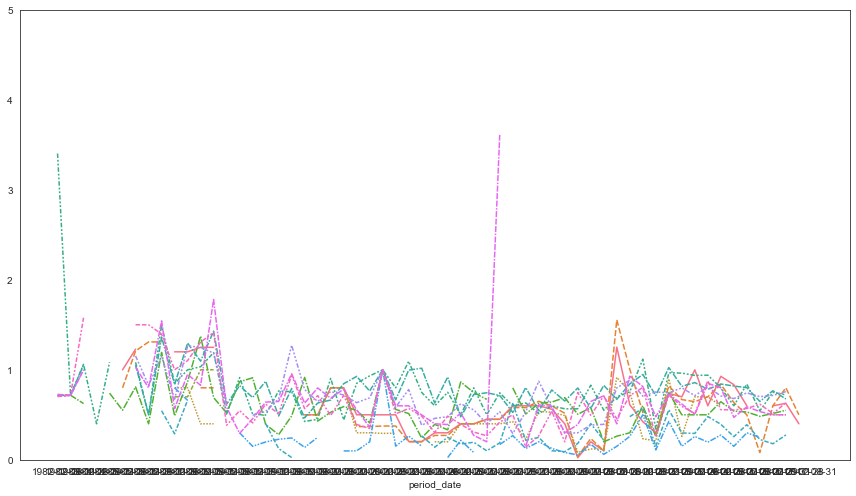

In [6]:
# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7), facecolor='w')
ax = sns.lineplot(data=temp,legend=False)
ax.set_ylim([0,5])
plt.tight_layout()
plt.show()

### Calculate summary of maize yield data

In [7]:
# Load yield data
yield1 = pd.read_hdf('./data/crop/SO_admin1_maize_yield.hdf'); yield1.columns.name = 'FNID'
yield2 = pd.read_hdf('./data/crop/SO_admin2_maize_yield.hdf'); yield2.columns.name = 'FNID'
# - only Gu season
yield1 = yield1[pd.to_datetime(yield1.index).month == 8]
yield1.index = pd.to_datetime(yield1.index).year
yield2 = yield2[pd.to_datetime(yield2.index).month == 8]
yield2.index = pd.to_datetime(yield2.index).year
# - fill missing years
yield1 = yield1.reindex(np.arange(yield1.index.min(), yield1.index.max()+1),fill_value=np.nan)
yield2 = yield2.reindex(np.arange(yield2.index.min(), yield2.index.max()+1),fill_value=np.nan)

# Percentage of records (1982-2017 (36) for admin1 and 1984-2017 (34) for admin2) and average yield
record1 = yield1.notna().sum(0)/len(yield1.index)
average1 = yield1.mean(skipna=True,axis=0)
data1 = pd.DataFrame({'record':record1, 'average':average1})
record2 = yield2.notna().sum(0)/len(yield2.index)
average2 = yield2.mean(skipna=True,axis=0)
data2 = pd.DataFrame({'record':record2, 'average':average2})
mapdata1 = shape1.merge(data1,how='outer',on='FNID')
mapdata2 = shape2.merge(data2,how='outer',on='FNID')
unreported1 = shape1[~np.isin(shape1['FNID'], data1.index)]
unreported2 = shape2[~np.isin(shape2['FNID'], data2.index)]

### Mapping yield data summary

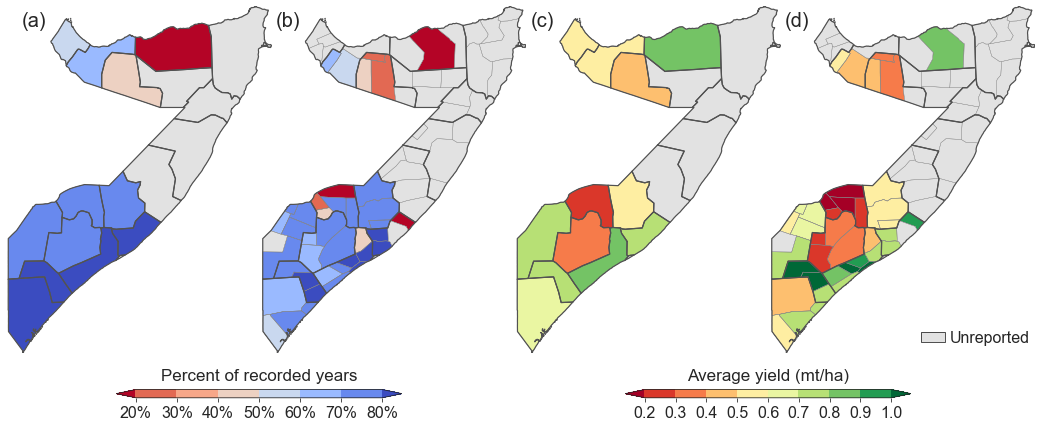

./figures/SO_maize_yield_summary_map.png is saved.


In [14]:
# Colormap
bounds1 = list(np.arange(0.2,0.9,0.1))
boundaries1 = [0]+bounds1+[100]
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'coolwarm_r', labloc='on', 
                                                          boundaries=boundaries1, extension='both')
bounds2 = list(np.arange(0.2,1.1,0.1))
boundaries2 = [0]+bounds2+[100]
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'RdYlGn', labloc='on', 
                                                          boundaries=boundaries2, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)', '(d)']
figlabel = ['Percent of recorded years','Average yield (mt/ha)']
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(14,6), facecolor='w')
for (i, el) in enumerate(['record','record','average','average']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    if el == 'record':
        cmap, norm, vmin, vmax = cmap1, norm1, vmin1, vmax1
    else:
        cmap, norm, vmin, vmax = cmap2, norm2, vmin2, vmax2
    if i % 2 == 0:
        mapdata1.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
        unreported1.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
        mapdata1.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
    else:
        mapdata2.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
        unreported2.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
        mapdata2.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
    # Figure number
    ax.annotate(fignumb[i], xy=(0.1, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-1)

# Colorbars
for i in [1,3]:
    ax = axes[i]
    cax = inset_axes(ax, width="60%", height="3%",
                     loc='lower left',
                     bbox_to_anchor=(-0.55, -0.13, 1.8, 0.8),
                     bbox_transform=ax.transAxes,borderpad=0)
    if i == 1:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='horizontal')
        cbar.ax.set_xticklabels(['%.f%%'%lb for lb in np.array(bounds1)*100], fontname='arial', fontsize=16)
        label = figlabel[0]
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='horizontal')
        cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds2)], fontname='arial', fontsize=16)
        label = figlabel[1]
    cbar.set_label(label, labelpad=-52, 
                   fontname='arial', fontsize=17, 
                   horizontalalignment='center')

# Colorbar for the unreported districts
cax2 = inset_axes(ax, width="46%", height="3.5%", bbox_to_anchor=(0.46, -0.74, 0.2, 0.8),bbox_transform=ax.transAxes,borderpad=0)
cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=ListedColormap('#E2E2E2'),ticks=[], orientation='horizontal')
cbar2.ax.text(1.2,0,'Unreported',fontname='arial', fontsize=16)
plt.show()

# Save a figure
if True:
    fn_save = './figures/SO_maize_yield_summary_map.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)